In [4]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF


In [6]:
zip_path = "BBC_News.zip"   
extract_path = "BBC_News_extracted"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

base_dir = os.path.join(extract_path, "BBC_News", "News Articles")


In [8]:
# Load documents
# -----------------------
docs = []
categories = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
for cat in categories:
    for fname in os.listdir(os.path.join(base_dir, cat)):
        if fname.endswith(".txt"):
            with open(os.path.join(base_dir, cat, fname), "r", encoding="latin-1") as f:
                docs.append({"doc_id": f"{cat}/{fname}", "category": cat, "text": f.read()})

df = pd.DataFrame(docs)


In [10]:
#  Vectorization
n_topics = 5
max_features = 2000


In [12]:
# Count vectorizer for LDA
count_vect = CountVectorizer(
    lowercase=True,
    stop_words="english",
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b",
    max_df=0.95,
    min_df=2,
    max_features=max_features
)
X_counts = count_vect.fit_transform(df["text"])


In [14]:
# TF-IDF vectorizer for NMF
tfidf_vect = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b",
    max_df=0.95,
    min_df=2,
    max_features=max_features
)
X_tfidf = tfidf_vect.fit_transform(df["text"])


In [16]:
# Topic Modeling
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=10)
lda_W = lda.fit_transform(X_counts)
lda_H = lda.components_

nmf = NMF(n_components=n_topics, random_state=42, init="nndsvda", max_iter=200)
nmf_W = nmf.fit_transform(X_tfidf)
nmf_H = nmf.components_


In [18]:
#  Helper function
def top_words_df(components, feature_names, topn=10, model_name="LDA"):
    rows = []
    for k, comp in enumerate(components):
        idx = np.argsort(comp)[::-1][:topn]
        for i in idx:
            rows.append({"model": model_name, "topic": k, "word": feature_names[i], "weight": float(comp[i])})
    return pd.DataFrame(rows)


In [20]:
#Extract topics
lda_topics_df = top_words_df(lda_H, count_vect.get_feature_names_out(), model_name="LDA")
nmf_topics_df = top_words_df(nmf_H, tfidf_vect.get_feature_names_out(), model_name="NMF")

df["LDA_dominant_topic"] = lda_W.argmax(axis=1)


In [26]:
# Save outputs
out_dir = "topic_modeling_outputs"
os.makedirs(out_dir, exist_ok=True)

lda_topics_df.to_csv(os.path.join(out_dir, "lda_topics_top_words.csv"), index=False)
nmf_topics_df.to_csv(os.path.join(out_dir, "nmf_topics_top_words.csv"), index=False)
df[["doc_id","category","LDA_dominant_topic"]].to_csv(os.path.join(out_dir, "documents_with_topics.csv"), index=False)



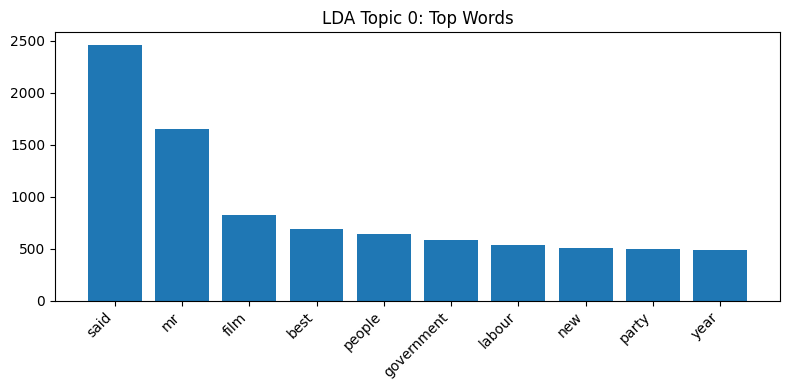

In [28]:
#  Visualization
topic0 = lda_topics_df[lda_topics_df["topic"] == 0].sort_values("weight", ascending=False)
plt.figure(figsize=(8,4))
plt.bar(topic0["word"], topic0["weight"])
plt.xticks(rotation=45, ha="right")
plt.title("LDA Topic 0: Top Words")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "lda_topic_0_top_words.png"))
plt.show()


In [30]:
#  Metrics
print("LDA perplexity (lower is better):", lda.perplexity(X_counts))
print("NMF reconstruction error (lower is better):", nmf.reconstruction_err_)
print("Outputs saved in:", out_dir)

LDA perplexity (lower is better): 982.0021136911874
NMF reconstruction error (lower is better): 44.798121419843774
Outputs saved in: topic_modeling_outputs
